## Udacity Machine Learning Nanodegree Capstone Project

#### Classifying Traffic Signs with a CNN

- The challenge of classifying traffic signs using machine learning has been attempted by many in the research community in the field of computer vision where a major competion held in 2012 by the Institut Fur Neuroinformatik where the winners went on to achieve an accurate recognition rate of 99.46%. 

- [Competition Website is here ](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) and the paper associated with it can be found here [J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011. ](https://www.researchgate.net/profile/Marc_Schlipsing/publication/224260296_The_German_Traffic_Sign_Recognition_Benchmark_A_multi-class_classification_competition/links/0fcfd508564a68aa76000000.pdf). 

- With such a high benchmark to shoot for, I feel this will be a great opportunity to put my new knowledge to use and learn some more while at it.

- First thing I have to do is to load the necessary libraries that I am going to use and keep coming back to add more when needed.

In [2]:
# import the necessary modules

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec
import pandas as pd
import os
from os.path import isfile,join
import csv
import glob
import pickle
import cv2
import itertools
import random
from random import *
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Input
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping  
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

### Load data from directory path

- I downloaded the data from the http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Structure and used an AWS EC2 instance to do this project as a regular desktop computer does not enough computing capability for such a task.


- the Data is stored  in folders with the following directory structure:-




 GTSRB    --->Final_Train --->Images  --->(folders from 00000 to 12629)  ---> Training Images(.ppm) + File annotation CSV file

    
 GTSRB    --->Final_Test --->Images  --->Images ---> Training Images(.ppm) + Class Label .CSV file   
  
  
- 

In [3]:
# use a helper function to get data from root path

#  this function returns a list of images and corresponding labels
def read_train_data(rootpath):
    images = []
    labels = []
    print('getting Images and Labels .......')
    for c in range(0,43):
        prefix = rootpath + format(c, '05d') + '/' 
        get_file = open(prefix + 'GT-'+ format(c, '05d') + '.csv')
        get_reader = csv.reader(get_file, delimiter=';') 
        next(get_reader) 
        for row in get_reader:
            images.append(plt.imread(prefix + row[0])) 
            labels.append(row[7]) 
        get_file.close()
    print('All Done!')  
    return images, labels

#  returns a list of images and list of corresponding labels
def read_test_data(rootpath):       
    print('getting Images and Labels .......')
    images = [] 
    labels = [] 
    get_reader = csv.reader(open(rootpath + 'GT-final_test.csv'), delimiter=';') 
    next(get_reader) 
    for row in get_reader:
        images.append(plt.imread(rootpath + row[0]))
        labels.append(row[7]) 
    print('All Done!')    
    return images, labels

In [4]:
# some image visualization function will come in handy for any previewing of images in their different state

def show_rand_images(Images, rows=8, cols=4, grayscale=False):  
    count = len(Images)
    num_images = rows * cols
    figure, axis = plt.subplots(cols, rows, figsize=(24, 9))
    figure.subplots_adjust(hspace = .2, wspace=.001)
    axis = axis.ravel()
    
    for i in range(num_images):
        index = random.randint(0,count-1)
        image = Images[index]
        axis[i].axis('off')
        if grayscale:
          axis[i].imshow(image, cmap='gray')
        else:
          axis[i].imshow(image)
        
def get_class_samples(get_class):
    class_collection = []
    for i in range(len(test_labels)):
        if test_labels[i]==str(get_class):
            class_collection.append(test_images[i])
    show_rand_images(class_collection)

In [5]:
# load train and test images from directories
test_images, test_labels = read_test_data('GTSRB/Final_Test/Images/')
train_images, train_labels = read_train_data('GTSRB/Final_Training/Images/')

getting Images and Labels .......
All Done!
getting Images and Labels .......
All Done!


In [6]:
# save data to pickle file for those times when I need to restart the notebook
pickle_dat = 'GTSRB_dat.pickle'
f = open(pickle_dat, 'wb')   
save = {
        'train_images': train_images,
        'train_labels': train_labels,
        'test_images': test_images,
        'test_labels': test_labels,}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()
print('pickle size:', os.stat(pickle_dat).st_size)

pickle size: 486441334


In [7]:
# retrieve data from pickle file
pickle_dat = 'GTSRB_dat.pickle'
with open(pickle_dat, 'rb') as f:
    save = pickle.load(f)
    train_images = save['train_images']
    train_labels = save['train_labels']
    test_images = save['test_images']
    test_labels = save['test_labels']
    del save  

In [8]:
# verify out data has the expected structure
print ("Shape of Test Images and Labels:", np.shape(test_images), np.shape(test_labels))
print ("Shape of Train Images and Labels:", np.shape(train_images), np.shape(train_labels))

Shape of Test Images and Labels: (12630,) (12630,)
Shape of Train Images and Labels: (39209,) (39209,)


### Exploratory Data Analysis


- in this section we will visualize the data and make observations on how we can improve it before feeding it to the Network

In [9]:
# Number of Images and Number of Classes
print ("Number of Training Images:", len(train_images))
print ("Number of Test Images:", len(test_images))
print ("Number of Classes: ", np.unique(test_labels).shape[0])

Number of Training Images: 39209
Number of Test Images: 12630
Number of Classes:  43





- From the above information, I see that the images are the right shape and the number of Classes match what is expected.
- Below we make observation on the loaded data before deciding on the preprossesing needed.

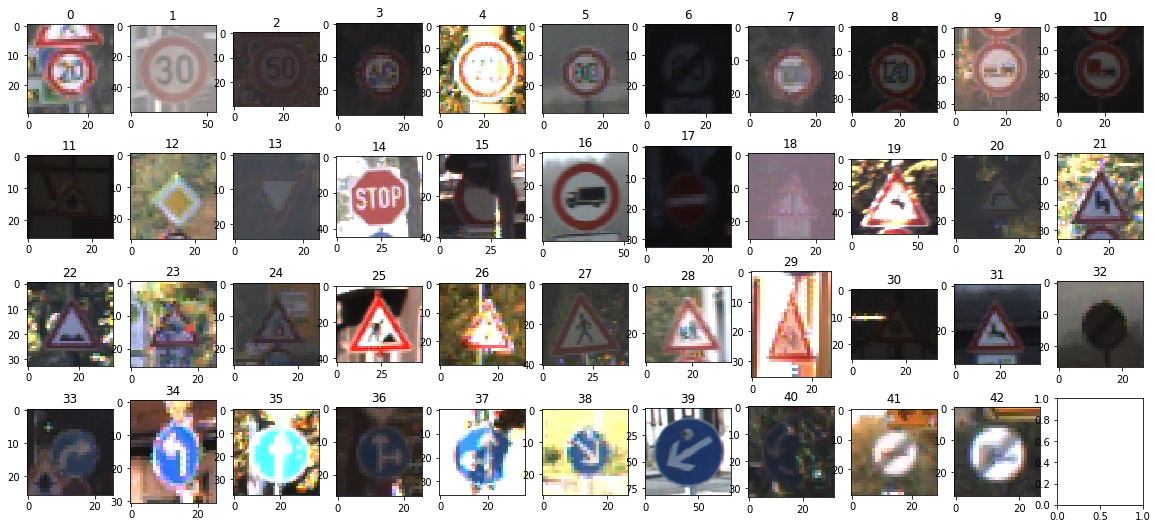

In [10]:
# show sample images from every class --Train Data
n_classes = np.unique(train_labels).shape[0]
samples_train = []
for i in range(n_classes):
    samples_train.append(train_images[list(train_labels).index(str(i))])
num_rows = 4
num_cols = 11
plt.figure(figsize=(20,9))
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)
ax = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]
for i, im in enumerate(samples_train):
    ax[i].imshow(im)
    ax[i].set_title(i, loc='center')

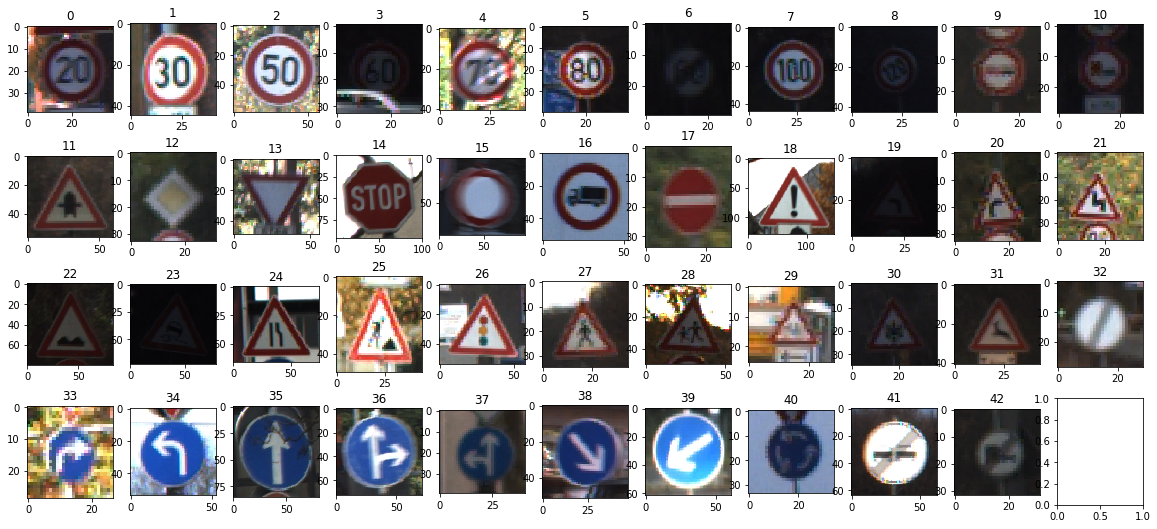

In [17]:
# show sample images from every class --Test Data
n_classes = np.unique(test_labels).shape[0]
samples_test = []
for i in range(n_classes):
    samples_test.append(test_images[test_labels.index(str(i))])
num_rows = 4
num_cols = 11
plt.figure(figsize=(20,9))
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)
ax = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]
for i, im in enumerate(samples_test):
    ax[i].imshow(im)
    ax[i].set_title(i, loc='center')

### Data Processing
.

- As we can see from the visualizations above from both the test and training data, the images are of different shapes and sizes - extreme examples that I can observe: 80x40 pixel, 120x140 pixels. 
- Clearly the images will need to be resized to the same size to make for a better generalized learning for the CNN model and much smaller than 100x100 pixels for our case since I have limited computing capability.
- Something to keep in mind is by resizing the images to smaller ones, I will be loosing some information that the model could use but as long as they are not too small, it's a fair trade off.
- The images also have  a wide range of illumination, ranging from too bright to too dark. Obvioulsy this is  something that I need to deal with if I want my model to generalize better on all data. 
- Histogram equalization comes to mind. This process distributes intensities in an image creating a higher contrast between different pixels. This is useful for those images where it is hard to make out the sign's borders due to poor lighting or image blurs.
- [This Wikipedia article is good place to start to understand Histogram Equalization](https://en.wikipedia.org/wiki/Histogram_equalization).

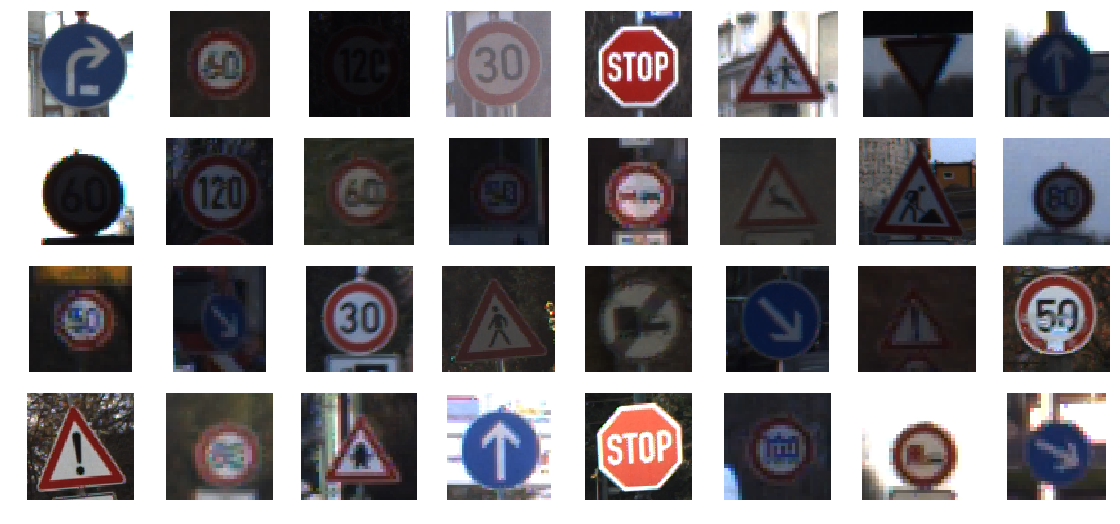

In [105]:
# sample train images
show_rand_images(train_images)

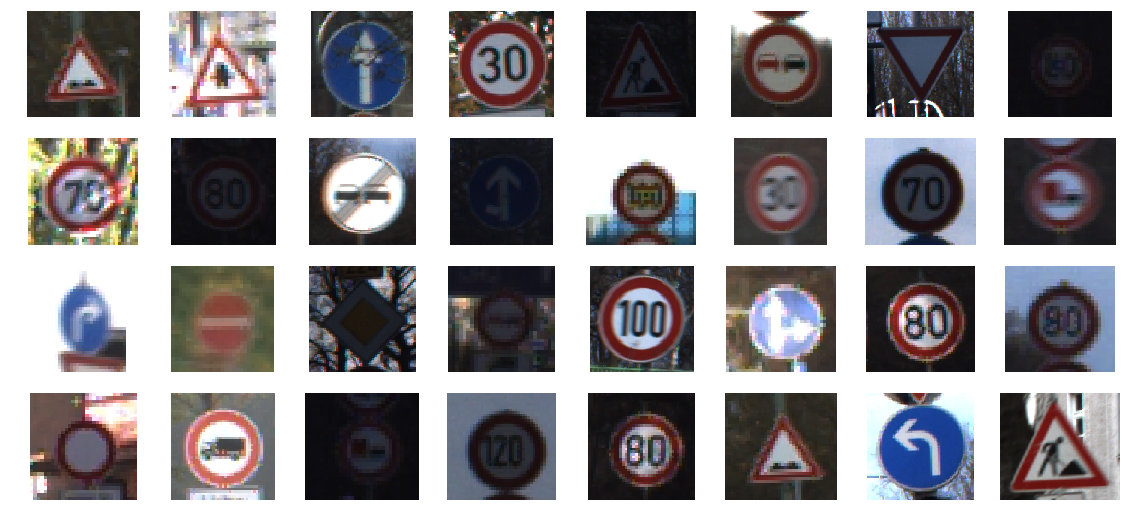

In [96]:
# sample test images
show_rand_images(test_images)

- I ran the above cells a few times to confirm my suspicions before resizing and performing histogram equalizations and they confirm the need to do so.

##### Balancing Classes

- Training a network on unbalanced data can lead to overfitting as the model will always statistically gravitate towards the heavily weighted classes. 
- To avoid this we can make sure the classes have a form of balance through a few different methods available in machine learning.

Maximum number of Images in a Class: 2250
Minimum amount of Images in a Class: 210


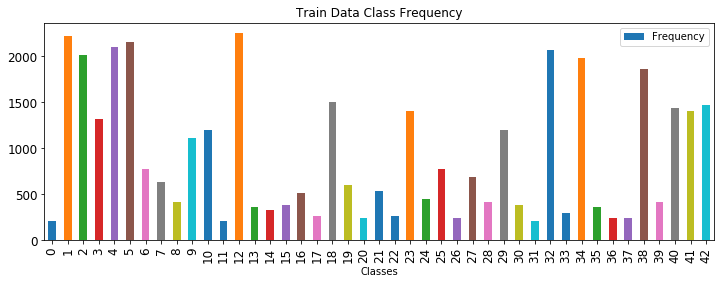

In [54]:
# explore Class distribution in both train and test data
num_classes_train = range(np.unique(train_labels).shape[0])
train_classes, train_frequency = np.unique(train_labels, return_counts=True)
train_dist = pd.DataFrame({'Classes': num_classes_train, 'Frequency': train_frequency})
train_dist.plot(x = 'Classes', y = 'Frequency', kind = 'bar', sort_columns = True,
                title = 'Train Data Class Frequency', figsize=(12,4), fontsize = 12)

print ("Maximum number of Images in a Class:", max(train_frequency))
print ("Minimum amount of Images in a Class:", min(train_frequency))

Maximum number of Images in a Class: 750
Minimum amount of Images in a Class: 60


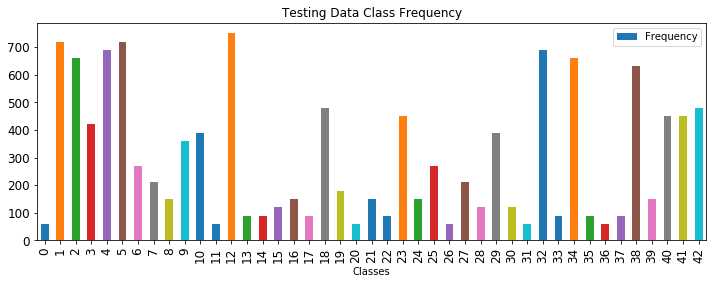

In [65]:
num_classes_test = range(np.unique(test_labels).shape[0])
test_classes, test_frequency = np.unique(test_labels, return_counts=True)
test_dist = pd.DataFrame({'Classes': num_classes_test, 'Frequency': test_frequency})
test_dist.plot(x = 'Classes', y = 'Frequency', kind = 'bar', sort_columns = True,
               title = 'Testing Data Class Frequency', figsize=(12,4), fontsize = 12)

print ("Maximum number of Images in a Class:", max(test_frequency))
print ("Minimum amount of Images in a Class:", min(test_frequency))

- The training and test data both have huge class imbalances. For the training set, maximum class count is class 12 at 2250 and minimum count is class 11 at 210. For the test set, the counts are 750 and 60 for the same classes as the train set. 
- Obviously, these classes need balancing but we can still run a model with the classes as they are but we will have to pay more attention to the model evaluation metrics we use. Can't use accuracy in that case.

- After trying out different methods, I will create extra images of the classes that fall short to try and bring the class representaion up to par. I will do this through image augmentation which is a process that creates different variations of the same image without the need to collect more data.

- I actually spent a lot of time on this step which was good for experience but in the end adding images through augmentation made the most sense to me. I explored passing a dictionary of class weights to the Keras fit funtion but was not very successful.

- As I am going to use Keras to build and train my network, I explored a function called [ImageDataGenerator](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which lets you generate these augmented images on the fly or from directory but had lots of problems implementing it and there is not enough time or documentation to build confidence in what I was doing. 
- I also experimented with the 'class_weight' and 'sample_weight' inputs in the Keras model training steps but after spending a lot of time on it, I encountered the same problems as above. I plan to revisit these two when I am done with this project.

In [6]:
# function lets you augment images by varying different parameters.
# samples shown below
# credit to____ https://github.com/vxy10/ImageAugmentation

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
   '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [7]:
# generate funtion more images by iterating through minority classes and adding needed images
def add_jittered_images(X_train, y_train, num):
    labels, counts = np.unique(y_train, return_counts=True)
    
    images_generated = 0
    new_images = []
    new_labels = []
    
    for i in range(len(labels)):
        if counts[i] < num:
            needed_imgs = num - counts[i]            
            print ('creating {} images for class {} .............'.format(needed_imgs, labels[i]))
                   
            indexes = [j for j,q in enumerate (y_train) if q==labels[i]]
            for k in range(needed_imgs):
                # get new image and label index
                index = random.choice(indexes)
                img = X_train[index]
                # create augmented version 
                new_images.append(transform_image(img,30,4,2)) 
                new_labels.append(y_train[index]) 
            
    # concatenate to original image, labels data
    X_train = np.concatenate([X_train, new_images])     
    y_train = np.concatenate([y_train, new_labels])
    
    # return expanded image arrays, labels data
    return X_train, y_train 

- Below I experimented with generating different amounts of images with above funtions and  finally settled for a higher count

In [8]:
import random
# train_balanced_imgs, train_balanced_labels = add_jittered_images(train_images, train_labels, 3000)  
train_balanced_imgs, train_balanced_labels = add_jittered_images(train_images, train_labels, 1200)    

creating 990 images for class 0 .............
creating 420 images for class 14 .............
creating 570 images for class 15 .............
creating 780 images for class 16 .............
creating 90 images for class 17 .............
creating 990 images for class 19 .............
creating 840 images for class 20 .............
creating 870 images for class 21 .............
creating 810 images for class 22 .............
creating 690 images for class 23 .............
creating 930 images for class 24 .............
creating 600 images for class 26 .............
creating 960 images for class 27 .............
creating 660 images for class 28 .............
creating 930 images for class 29 .............
creating 750 images for class 30 .............
creating 420 images for class 31 .............
creating 960 images for class 32 .............
creating 511 images for class 33 .............
creating 780 images for class 34 .............
creating 810 images for class 36 .............
creating 990 im

In [17]:
print ('Train IMAGES size before augmentation/jittering: {} --> After: {} '\
       .format(len(train_images), len(train_balanced_imgs)))
print ('Train LABELS size before augmentation/jittering: {} --> After: {} '\
       .format(len(train_labels), len(train_balanced_labels)))

Train IMAGES size before augmentation/jittering: 39209 --> After: 60000 
Train LABELS size before augmentation/jittering: 39209 --> After: 60000 


- At this stage we can visualize the new class distribution in our training data.
- I did not generate any new images for the test set as we dont use this for training our model but rather to check it's accuracy so it's important we don't tamper with this set.

Maximum number of Images in a Class: 2250
Minimum amount of Images in a Class: 1200


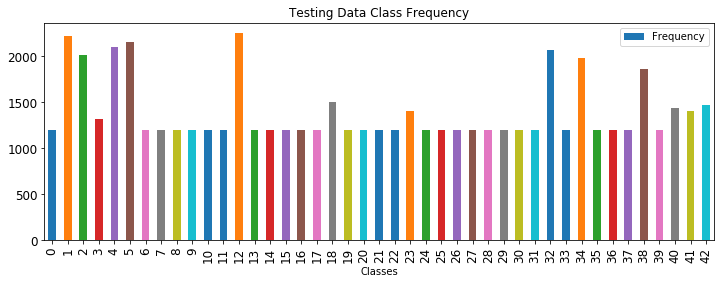

In [69]:
num_classes_test = range(np.unique(train_balanced_labels).shape[0])
test_classes, test_frequency = np.unique(train_balanced_labels, return_counts=True)
test_dist = pd.DataFrame({'Classes': num_classes_test, 'Frequency': test_frequency})
test_dist.plot(x = 'Classes', y = 'Frequency', kind = 'bar', sort_columns = True,
               title = 'Testing Data Class Frequency', figsize=(12,4), fontsize = 12)

print ("Maximum number of Images in a Class:", max(test_frequency))
print ("Minimum amount of Images in a Class:", min(test_frequency))

- As we can see below, the new images have been rotated for a range 30 degrees both ways, applied affine tranform for a range of 3 and  translations for a range of 2.
- As I mention before, this processes took me a lot of time and part of that was because of the trial and error to arrive at 'optimal' numbers and model experimentations with resulting numbers.
- I realize some of these work is highly inefficient, but it was a great learning  experience and can use that experience next time. 
- The one conclusion I can make at this point is that preparing your data to feed to a machine learning algorithim is by far the most energy consuming but without good data, you might as well forget about building a model in the first place.

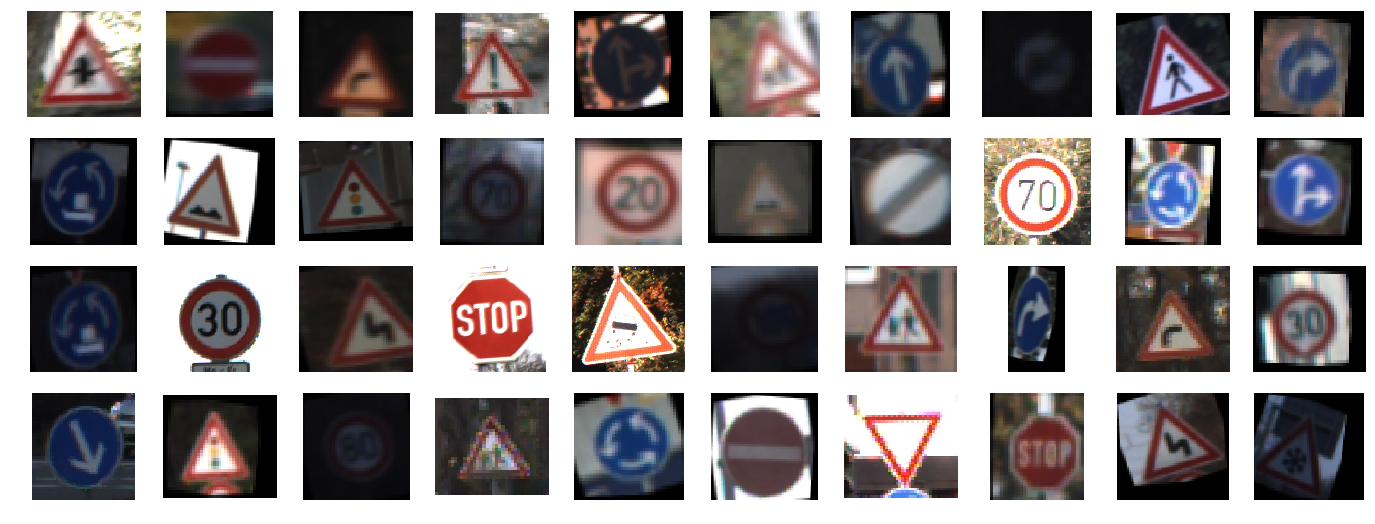

In [28]:
# sample balanced images
show_rand_images(train_balanced_imgs,rows=10,cols=4)

### More Data Preprocessing

- The data processing at this stage was applied to relevant dataset including the newly created train images.
- From previous observations, there was still a a lot of work left before we had clean data that was good enough to be fed into our model. 
- Below I resized the images from both train and test sets to 48 by 48 pixels. I ran a few trial models with different resizes of 32 by 32 pixels and they didn't perform as well compared to the 48 by 48.
- Like I mentioned before, we are loosing some information but I believe 48 pixels is still large enough for the model to extract enough information from.
- Next I equalized the histogram on both train and test images to increase the contrast which will make it easier for my model to extract features from.
- For most of the image processing, I used OpenCV which is straight forward to use and only gets better as you use it more. I used both the [CLAHE and straight forward equalizations](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html) available with OpenCV but did not see any noticable advantages of one over the other. Most of it came down to the actual parameters passed to those funtions. I did not try both methods on the each other.
- Lastly I also created a Grey scale variation of the train and test data to experiment on the models. There is a [good discusion on SO](https://stackoverflow.com/questions/12752168/why-we-should-use-gray-scale-for-image-processing) about why grey images are better for image recognition but one thing I have seen come up a lot is that color images increase the complexities from which the model has to learn from. With the color dimension, features grow significantly more.
- I should mention that the above three image processes were performed on both train and test data. As oposed to the data augmentation, these processes enhance the images and help the model learn better but also keeps both sets of data on the same field.
- Below is the different processes and relevant visualizations.

Sample Shape (48, 48, 3)


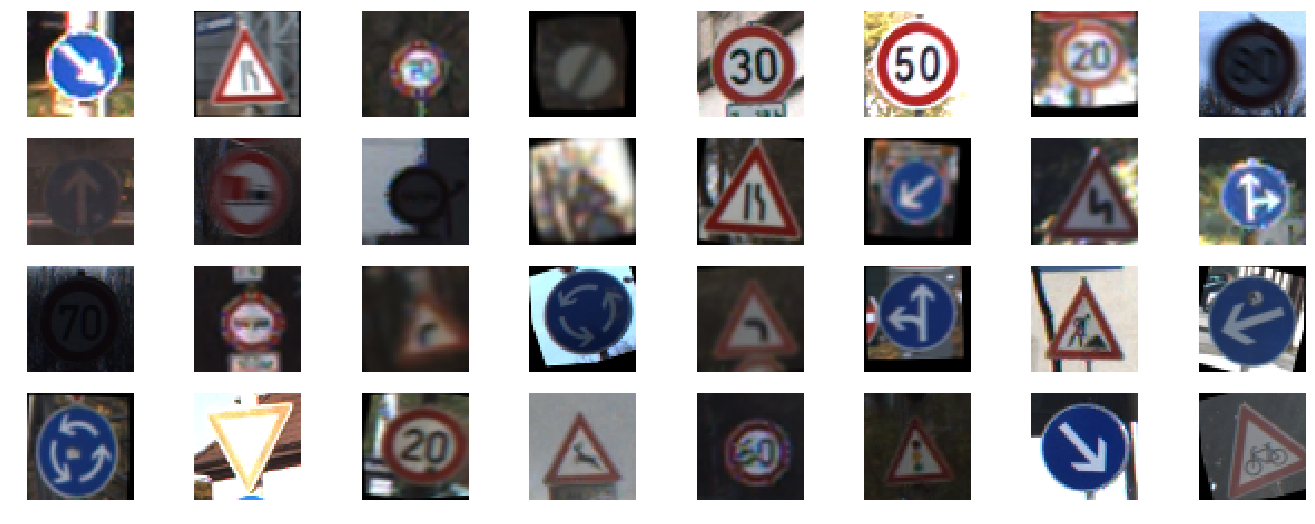

In [9]:
# convert to 48*48*3 pixels
def resized48p(img):
    img_resized = cv2.resize(img, (48,48), interpolation=cv2.INTER_CUBIC)
    return img_resized

trainSized48p = np.array([resized48p(img) for img in train_balanced_imgs])
testSized48p = np.array([resized48p(img) for img in test_images])

# show samples
print ('Sample Shape {}'.format(testSized48p[500].shape))
show_rand_images(trainSized48p)

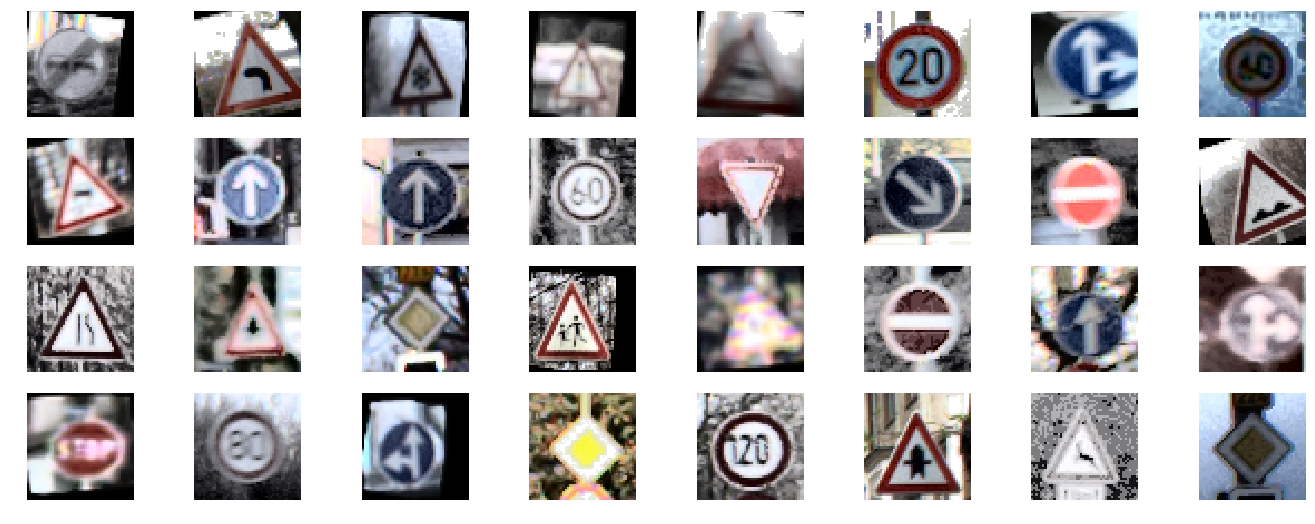

In [10]:
# one variation of Histogram Equalization
def color_img_hist_equal(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output

trainSizedColorHist48p = np.array([color_img_hist_equal(img) for img in trainSized48p])
testSizedColorHist48p = np.array([color_img_hist_equal(img) for img in testSized48p])

# show samples
show_rand_images(trainSizedColorHist48p)

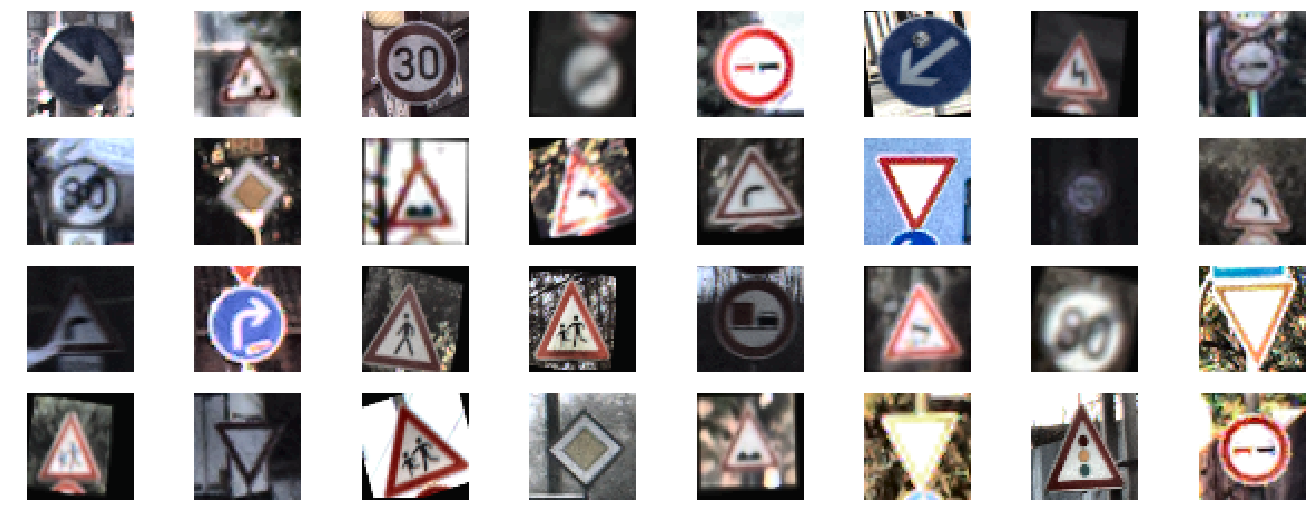

In [11]:
# second variation of Histogram Equalization

def hist_equalCLAHE(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(2,2)) # default clip=2.0
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb

trainSizedColorCLAHE48p = np.array([hist_equalCLAHE(img) for img in trainSized48p])
testSizedColorCLAHE48p = np.array([hist_equalCLAHE(img) for img in testSized48p])

show_rand_images(trainSizedColorCLAHE48p)

Sample Shape (48, 48)


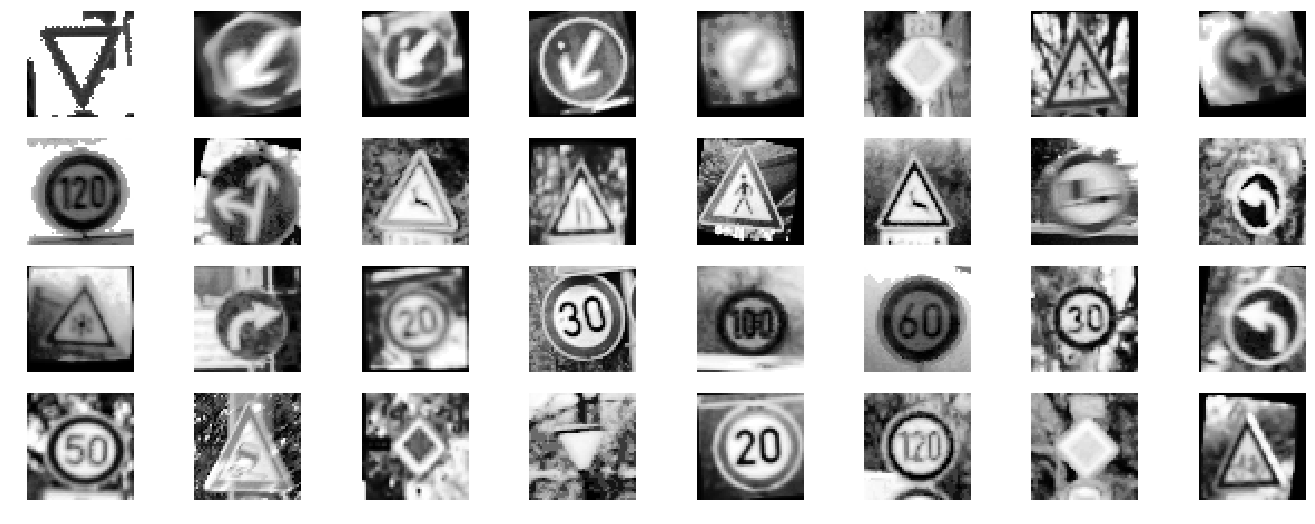

In [12]:
# convert to grayscale
def conv_2_gray(img):
    im_gray = np.zeros(img.shape,dtype=np.uint8)
    im_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return im_gray

trainEqualizedGray48p = np.array([conv_2_gray(img) for img in trainSizedColorHist48p])
testEqualizedGray48p = np.array([conv_2_gray(img) for img in testSizedColorHist48p])

# show samples
print ('Sample Shape {}'.format(trainEqualizedGray48p[500].shape))
show_rand_images((trainEqualizedGray48p),grayscale=True)

### Define Model Architecture, Training and Parameter Tuning
- This was a very great part of the project as I got to experiment with so much of what data I had created and processed.
- With so many model configurations to choose from, it was hard to decide where to start from so I did a bit more research on the models that performed well in image classification tasks. 
- It turns out that Keras has some of these models that can be preloaded and studied at length or even used through tranferred learning.
- [Available models on Keras](https://keras.io/applications/#available-models)
- The one model that I spent a lot of time on was the [VGG16](https://arxiv.org/abs/1409.1556) as it was very straight forward to understand. The architecture is very easy to follow from layer to layer.
![alt text](http://book.paddlepaddle.org/03.image_classification/image/vgg16.png)


- For all the models experimented with I ran the same parameters on 4 sets of image data:
    - Original Images
    - Resized, Histogram Equalized and Color Images
    - Resized, Histogram Equalized and Grayscale
    - Resized, Histogram Equalized, Grayscale and Gaussian Blurred. ( this bit is not visualized as it performed poorly compared to the other datasets.)
- I took my inspiration from the VGG16 and first built a replica model which did not perform so well as compared to later iterations. Come to think of it the original VGG16 network had heavy parameters because it was trained for a very long time.
- From there, through trial and error I adjusted different parameters and stayed with the models that showed an improvement.
- I normalized the images to the range (0,255) which got rid of the negative numbered pixels and large variations making it more efficient for a computer to analayse and perform computations. I aslo tried rescaling them to a range of (0, 1) but the former performed better in all trial runs. I am not sure exactly why but this is something I want to understand going forward.
- Next, I reshaped the data to a fourth dimension which is the input shape that Keras takes and lastly one-hot encoded the 43 classes because that is the only way the computer will make sense of these labels.
- After performing the above steps on all input data, I built the models by first initiating a sequential model which is what you do with Keras.
- After a good bit of trial and error (many days), I settled for variations of the following order:-
    - 2 consecutive convolutional layers -(32 x 32)filter, (2 x 2)kernel size, Relu activation
    - DropOut layer(varying 0.1 - 0.3)
    - MaxPooling layer
    - 2 consecutive convolutional layers - (64 x 64)filter, (2 x 2)kernel size, Relu activation
    - DropOut layer(varying 0.1 - 0.3)
    - MaxPooling layer
    - 2 consecutive convolutional layers - (128 x 128)filter, (2 x 2)kernel size, Relu activation
    - DropOut layer(varying 0.1 - 0.3)
    - MaxPooling layer
    - 2 consecutive convolutional layers - (256 x 256)filter, (2 x 2)kernel size, Relu activation
    - DropOut layer(varying 0.1 - 0.3)
    - MaxPooling layer
    - Flatten layer 
    - 2 Dense layers
    - Dropout (0.5)
    - Dense layer( Softmax activation / class prediction) 
    - Same Padding was used on all the Convolutional layers as not to loose any extra information at the image edges.
    
- In total my final models had 21 layers with this architecture for the varying data inputs mentioned before.
- The validation data was obtained by isolating 20% of the train data and setting that aside for the model to validate on.
- For my optimizers, I settled for the 'adam' optimizer with default parameters even though I did experiment with a different learning rate. I also tried different combinations of parameters with SGD.
- Different Batch  sizes were experimented with but the larger the batches the more I would run into low memory scenarios
- Drop out layers were utilized to minimize overfitting and was tuned by trial and error but I did take cue from the VGG16 with adding a larger droput in the last Dense layer.
- Additionaly, the 'adam' optimizer with default parameters has been shown to be most effective as it converges faster with fewer iterations. 
![Adam Optimizer](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron.png)
- More on [gradient descent optimizers for machine learning](https://arxiv.org/abs/1609.04747)

#### Model  defined - Final 4 models

train data shape (103200, 48, 48, 3)
validation data shape (25800, 48, 48, 3)
test data shape (12630, 48, 48, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 48, 48, 32)        416       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 32)        4128      
_________________________________________________________________
block1_drop (Dropout)        (None, 48, 48, 32)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 64)        8256      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 64)        16448     
_____________________________

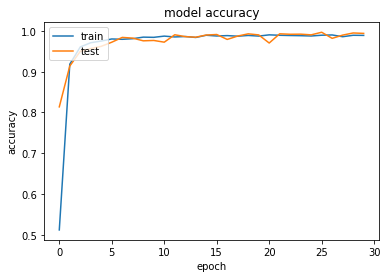

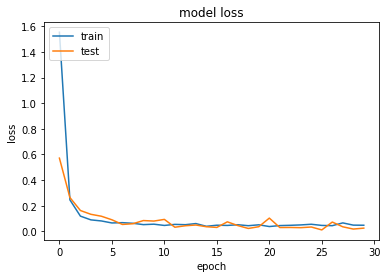

In [18]:
"""   
Model 1:     48 pixels -- Resized and Histogram Equalized Images  
"""

X_train, y_train, X_test, y_test = trainSizedColorHist48p, train_balanced_labels, testSizedColorHist48p, test_labels

# split train, validation and test datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Normalize - rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_valid = X_valid.astype('float32')/255
X_test = X_test.astype('float32')/255 

# reshape for input to network
X_train = X_train.reshape(X_train.shape[0], 48, 48, 3)
X_valid = X_valid.reshape(X_valid.shape[0], 48, 48, 3)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 3)

print ('train data shape', X_train.shape)
print ('validation data shape', X_valid.shape)
print ('test data shape', X_test.shape)

y_train = np_utils.to_categorical(y_train, num_classes=43)
y_valid = np_utils.to_categorical(y_valid, num_classes=43)
y_test = np_utils.to_categorical(y_test, num_classes=43)

#  Define the Model Architecture
model = Sequential()

model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', input_shape=(48,48,3), activation='relu', 
                        name='block1_conv1'))
model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', activation='relu', name='block1_conv2'))
model.add(Dropout(0.25, name='block1_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block1_pool'))

model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv1'))
model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv2'))
model.add(Dropout(0.25, name='block2_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block2_pool'))

model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv1'))
model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv2'))
model.add(Dropout(0.25, name='block3_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block3_pool'))

model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv1'))
model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv2'))
model.add(Dropout(0.25, name='block4_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block4_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(2048, activation='relu', name='fc1'))
model.add(Dense(2048, activation='relu', name='fc2'))
model.add(Dropout(0.5, name='dense_drop1'))
model.add(Dense(43, activation='softmax', name='predictions'))
model.summary()

# Compile and Fit the Model 

epochs = 30
batch_size = 128
epochs_for_EarlyStopping = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=epochs_for_EarlyStopping)
checkpointer = ModelCheckpoint(filepath='GTSRB_colorHist48p_01_model.hdf5', verbose=0, save_best_only=True)

optimizer = Adam
# optimizer = Adam(lr=1.0e-4)
# optimizer = Adam(lr=0.5e-3)
# optimizer = SGD(lr=1.0e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_valid,y_valid), 
                    verbose=1,
                    callbacks=[checkpointer,early_stopping]) 

# model.save('GTSRB_colorHist48p_01_model.hdf5')
# ___________________________________________________________________________________________

# load the weights that yielded the best validation accuracy
model.load_weights('GTSRB_colorHist48p_01_model.hdf5')

# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]
loss = score[0]

# print test accuracy
print ('\nTest accuracy: %.4f%%' % accuracy)
print ('Test loss: %.4f%%' % loss)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

train data shape (48000, 48, 48, 3)
validation data shape (12000, 48, 48, 3)
test data shape (12630, 48, 48, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 48, 48, 32)        416       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 32)        4128      
_________________________________________________________________
block1_drop (Dropout)        (None, 48, 48, 32)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 64)        8256      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 64)        16448     
______________________________

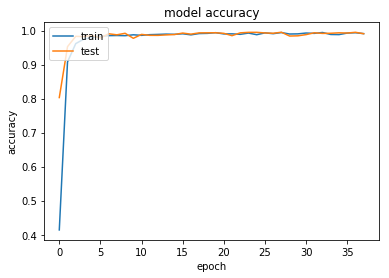

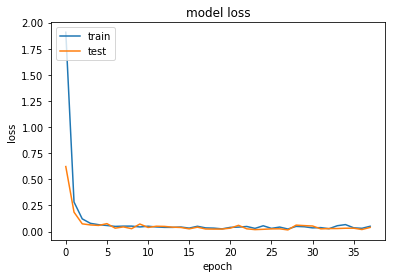

In [87]:
"""
Model 2:     48*48*3 -- Resized and Histogram Equalized Images
"""

X_train, y_train, X_test, y_test = trainSizedColorCLAHE48p, train_balanced_labels, testSizedColorCLAHE48p, test_labels

# split train, validation and test datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Normalize - rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_valid = X_valid.astype('float32')/255
X_test = X_test.astype('float32')/255 

# reshape for input to network
X_train = X_train.reshape(X_train.shape[0], 48, 48, 3)
X_valid = X_valid.reshape(X_valid.shape[0], 48, 48, 3)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 3)

print ('train data shape', X_train.shape)
print ('validation data shape', X_valid.shape)
print ('test data shape', X_test.shape)

y_train = np_utils.to_categorical(y_train, num_classes=43)
y_valid = np_utils.to_categorical(y_valid, num_classes=43)
y_test = np_utils.to_categorical(y_test, num_classes=43)

#  Define the Model Architecture
model = Sequential()

model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', input_shape=(48, 48, 3), activation='relu',
                        name='block1_conv1'))
model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', activation='relu', name='block1_conv2'))
model.add(Dropout(0.25, name='block1_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block1_pool'))

model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv1'))
model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv2'))
model.add(Dropout(0.25, name='block2_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block2_pool'))

model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv1'))
model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv2'))
model.add(Dropout(0.25, name='block3_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block3_pool'))

model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv1'))
model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv2'))
model.add(Dropout(0.25, name='block4_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block4_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(2048, activation='relu', name='fc1'))
model.add(Dense(2048, activation='relu', name='fc2'))
model.add(Dropout(0.5, name='dense_drop1'))
model.add(Dense(43, activation='softmax', name='predictions'))
model.summary()

# Compile and Fit the Model 
epochs = 40
batch_size = 128
epochs_for_EarlyStopping = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=epochs_for_EarlyStopping)
checkpointer = ModelCheckpoint(filepath='GTSRB_colorHist48p_model_02.hdf5', verbose=0, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_valid,y_valid), 
                    verbose=1,
                    callbacks=[checkpointer,early_stopping])

# model.save('GTSRB_colorHist48p_model_02.hdf5')

# ___________________________________________________________________________________________


# load the weights that yielded the best validation accuracy
model.load_weights('GTSRB_colorHist48p_model_02.hdf5')

# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]
loss = score[0]

# print test accuracy
print ('\nTest accuracy: %.4f%%' % accuracy)
print ('Test loss: %.4f%%' % loss)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

train data shape (103200, 48, 48, 1)
validation data shape (25800, 48, 48, 1)
test data shape (12630, 48, 48, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 48, 48, 32)        160       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 32)        4128      
_________________________________________________________________
block1_drop (Dropout)        (None, 48, 48, 32)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 64)        8256      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 64)        16448     
_____________________________

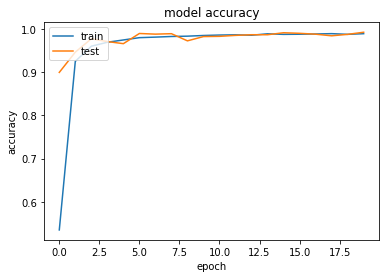

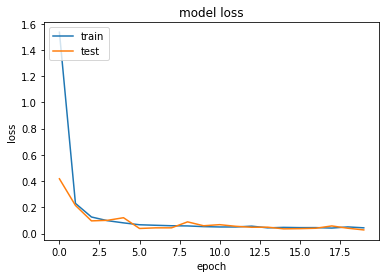

In [91]:
"""
Model 3:     48*48*3 -- Grayed, Resized and Histogram Equalized Images
"""

X_train, y_train, X_test, y_test = trainEqualizedGray48p, train_balanced_labels, testEqualizedGray48p, test_labels

# split train, validation and test datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Normalize - rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_valid = X_valid.astype('float32')/255
X_test = X_test.astype('float32')/255 

# reshape for input to network
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

print ('train data shape', X_train.shape)
print ('validation data shape', X_valid.shape)
print ('test data shape', X_test.shape)

y_train = np_utils.to_categorical(y_train, num_classes=43)
y_valid = np_utils.to_categorical(y_valid, num_classes=43)
y_test = np_utils.to_categorical(y_test, num_classes=43)

#  Define the Model Architecture
model = Sequential()

model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', input_shape=(48, 48, 1), activation='relu', 
                        name='block1_conv1'))
model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', activation='relu', name='block1_conv2'))
model.add(Dropout(0.25, name='block1_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block1_pool'))

model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv1'))
model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv2'))
model.add(Dropout(0.25, name='block2_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block2_pool'))

model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv1'))
model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv2'))
model.add(Dropout(0.25, name='block3_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block3_pool'))

model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv1'))
model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv2'))
model.add(Dropout(0.25, name='block4_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block4_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(2048, activation='relu', name='fc1'))
model.add(Dense(2048, activation='relu', name='fc2'))
model.add(Dropout(0.5, name='dense_drop1'))
model.add(Dense(43, activation='softmax', name='predictions'))
model.summary()

# Compile and Fit the Model 
epochs = 30
batch_size = 128
epochs_for_EarlyStopping = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=epochs_for_EarlyStopping)
checkpointer = ModelCheckpoint(filepath='GTSRB_grayed48p_model_01.hdf5', verbose=0, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_valid,y_valid), 
                    verbose=1,
                    callbacks=[checkpointer,early_stopping]) # try shuffle=True

# model.save('GTSRB_grayed48p_model_01.hdf5')

# ___________________________________________________________________________________________


# load the weights that yielded the best validation accuracy
model.load_weights('GTSRB_grayed48p_model_01.hdf5')

# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]
loss = score[0]

# print test accuracy
print ('\nTest accuracy: %.4f%%' % accuracy)
print ('Test loss: %.4f%%' % loss)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

train data shape (103200, 48, 48, 1)
validation data shape (25800, 48, 48, 1)
test data shape (12630, 48, 48, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 48, 48, 32)        160       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 32)        4128      
_________________________________________________________________
block1_drop (Dropout)        (None, 48, 48, 32)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 64)        8256      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 64)        16448     
_____________________________

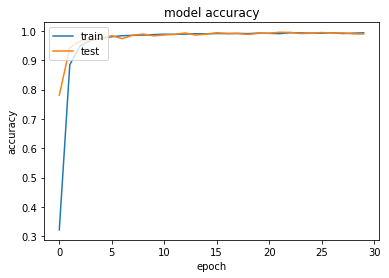

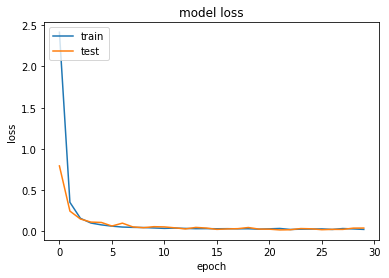

In [94]:
"""
Model 4:     Grayed, Resized and Histogram Equalized Images
"""

X_train, y_train, X_test, y_test = trainEqualizedGray48p, train_balanced_labels, testEqualizedGray48p, test_labels

# split train, validation and test datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Normalize - rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_valid = X_valid.astype('float32')/255
X_test = X_test.astype('float32')/255 

# reshape for input to network
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

print ('train data shape', X_train.shape)
print ('validation data shape', X_valid.shape)
print ('test data shape', X_test.shape)

y_train = np_utils.to_categorical(y_train, num_classes=43)
y_valid = np_utils.to_categorical(y_valid, num_classes=43)
y_test = np_utils.to_categorical(y_test, num_classes=43)

#  Define the Model Architecture
model = Sequential()

model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', input_shape=(48, 48, 1), activation='relu', 
                        name='block1_conv1'))
model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', activation='relu', name='block1_conv2'))
model.add(Dropout(0.25, name='block1_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block1_pool'))

model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv1'))
model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv2'))
model.add(Dropout(0.25, name='block2_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block2_pool'))

model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv1'))
model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv2'))
model.add(Dropout(0.25, name='block3_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block3_pool'))

model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv1'))
model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv2'))
model.add(Dropout(0.25, name='block4_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block4_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(2048, activation='relu', name='fc1'))
model.add(Dense(2048, activation='relu', name='fc2'))
model.add(Dropout(0.5, name='dense_drop1'))
model.add(Dense(43, activation='softmax', name='predictions'))
model.summary()

# Compile and Fit the Model 
epochs = 30
batch_size = 256
epochs_for_EarlyStopping = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=epochs_for_EarlyStopping)
checkpointer = ModelCheckpoint(filepath='GTSRB_grayed48p_model_02.hdf5', verbose=0, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_valid,y_valid), 
                    verbose=1,
                    callbacks=[checkpointer,early_stopping]) 

# model.save('GTSRB_grayed48p_model_02.hdf5')
# ___________________________________________________________________________________________


# load the weights that yielded the best validation accuracy
model.load_weights('GTSRB_grayed48p_model_02.hdf5')

# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]
loss = score[0]

# print test accuracy
print ('\nTest accuracy: %.4f%%' % accuracy)
print ('Test loss: %.4f%%' % loss)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

                                                             **Final Models Summary  **
  
Input Shape |  Input Data |  Model |  Accuracy  
---: | :---: | :---: | :---
48 x 48 | trainSizedColorHist48p | model 1 | 97.8939%
48 x 48 | trainSizedColorCLAHE48p |  model 2 |  96.8884% 
48 x 48 | trainEqualizedGray48p | model 3 | 97.6326%
48 x 48 | trainEqualizedGray48p | model 4 |  96.9913%

In [25]:
"""THIS CELL IS FOR LOADING MODELS ON THE FLY TO DO SOME MORE ANALYSIS"""

model = load_model('GTSRB_colorHist48p_01_model.hdf5')
# model = load_model('GTSRB_grayed48p_model_02.hdf5')
# model = load_model('GTSRB_colorHist48p_01_model.hdf5')
# ___________________________________________________________

In [25]:
"""   
Model 1:     48 pixels -- Resized and Histogram Equalized Images  
ReRun with different random states to evaluate Model Robustness
The results are shown in the cells below
"""

X_train, y_train, X_test, y_test = trainSizedColorHist48p, train_balanced_labels, testSizedColorHist48p, test_labels

# split train, validation and test datasets
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=100)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=200)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=300)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=400)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=500)

# Normalize - rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_valid = X_valid.astype('float32')/255
X_test = X_test.astype('float32')/255 

# reshape for input to network
X_train = X_train.reshape(X_train.shape[0], 48, 48, 3)
X_valid = X_valid.reshape(X_valid.shape[0], 48, 48, 3)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 3)

print ('train data shape', X_train.shape)
print ('validation data shape', X_valid.shape)
print ('test data shape', X_test.shape)

y_train = np_utils.to_categorical(y_train, num_classes=43)
y_valid = np_utils.to_categorical(y_valid, num_classes=43)
y_test = np_utils.to_categorical(y_test, num_classes=43)

#  Define the Model Architecture
model = Sequential()

model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', input_shape=(48,48,3), activation='relu', 
                        name='block1_conv1'))
model.add(Convolution2D(filters=32, kernel_size=(2,2), padding='same', activation='relu', name='block1_conv2'))
model.add(Dropout(0.25, name='block1_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block1_pool'))

model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv1'))
model.add(Convolution2D(filters=64, kernel_size=(2,2), padding='same', activation='relu', name='block2_conv2'))
model.add(Dropout(0.25, name='block2_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block2_pool'))

model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv1'))
model.add(Convolution2D(filters=128, kernel_size=(2,2), padding='same', activation='relu', name='block3_conv2'))
model.add(Dropout(0.25, name='block3_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block3_pool'))

model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv1'))
model.add(Convolution2D(filters=256, kernel_size=(2,2), padding='same', activation='relu', name='block4_conv2'))
model.add(Dropout(0.25, name='block4_drop'))
model.add(MaxPooling2D(pool_size=(2,2), name='block4_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(2048, activation='relu', name='fc1'))
model.add(Dense(2048, activation='relu', name='fc2'))
model.add(Dropout(0.5, name='dense_drop1'))
model.add(Dense(43, activation='softmax', name='predictions'))
model.summary()

# Compile and Fit the Model 

epochs = 30
batch_size = 128
epochs_for_EarlyStopping = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=epochs_for_EarlyStopping)
checkpointer = ModelCheckpoint(filepath='GTSRB_colorHist48p_Test_model.hdf5', verbose=0, save_best_only=True)

optimizer = 'adam'
# optimizer = Adam(lr=1.0e-4)
# optimizer = Adam(lr=0.5e-3)
# optimizer = SGD(lr=1.0e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_valid,y_valid), 
                    verbose=1,
                    callbacks=[checkpointer,early_stopping]) 

train data shape (48000, 48, 48, 3)
validation data shape (12000, 48, 48, 3)
test data shape (12630, 48, 48, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 48, 48, 32)        416       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 32)        4128      
_________________________________________________________________
block1_drop (Dropout)        (None, 48, 48, 32)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 64)        8256      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 64)        16448     
______________________________

In [14]:
# # evaluate test accuracy
# score = model.evaluate(X_test, y_test, verbose=0)
# accuracy = 100*score[1]
# # acc_1 = accuracy
# loss = score[0]

# print test accuracy
# print('random_state=100')
# print ('\nTest accuracy: %.4f%%' % accuracy)
# print ('Test loss: %.4f%%' % loss)

random_state=100

Test accuracy: 96.5400%
Test loss: 0.1655%


In [17]:
# # evaluate test accuracy
# score = model.evaluate(X_test, y_test, verbose=0)
# accuracy = 100*score[1]
# acc_2 = accuracy
# loss = score[0]

# # print test accuracy
# print('random_state=200')
# print ('\nTest accuracy: %.4f%%' % accuracy)
# print ('Test loss: %.4f%%' % loss)

random_state=200

Test accuracy: 96.3104%
Test loss: 0.1489%


In [20]:
# # evaluate test accuracy
# score = model.evaluate(X_test, y_test, verbose=0)
# accuracy = 100*score[1]
# acc_3 = accuracy
# loss = score[0]

# # print test accuracy
# print('random_state=300')
# print ('\nTest accuracy: %.4f%%' % accuracy)
# print ('Test loss: %.4f%%' % loss)

random_state=300

Test accuracy: 96.4925%
Test loss: 0.1382%


In [23]:
# # evaluate test accuracy
# score = model.evaluate(X_test, y_test, verbose=0)
# accuracy = 100*score[1]
# acc_4 = accuracy
# loss = score[0]

# # print test accuracy
# print('random_state=400')
# print ('\nTest accuracy: %.4f%%' % accuracy)
# print ('Test loss: %.4f%%' % loss)

random_state=400

Test accuracy: 96.7696%
Test loss: 0.1253%


In [26]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]
acc_5 = accuracy
loss = score[0]

# print test accuracy
print('random_state=500')
print ('\nTest accuracy: %.4f%%' % accuracy)
print ('Test loss: %.4f%%' % loss)

random_state=500

Test accuracy: 97.0071%
Test loss: 0.1411%


In [29]:
accs = [acc_1,acc_2,acc_3,acc_4,acc_5]
print(accs)

print('Accuracy Mean: ', np.mean(accs, dtype=np.float64))
print('Accuracy Variance: ', np.var(accs, dtype=np.float64))

[96.539984166574968, 96.310372131737282, 96.492478231164256, 96.769596201412654, 97.007125889792491]
Accuracy Mean:  96.6239113241
Accuracy Variance:  0.0581405475346


#### Make predictions with best model:

- I think the above models performed well in theory but now it is time to make preditions and understand where we might have gone wrong or could improve.
- I feel comfortable that **accuarcy** is an appropriate metric for evaluating the above models as steps to balance the classes were performed and visuations confirmed this.
- The first model performed the best with an accuracy of **97.89%** and the others coming very close.
- I will now go on to to visualize a **Confusion Matrix** which should give us an in depth look at the best model short comings.

#### Predictions and Evaluations


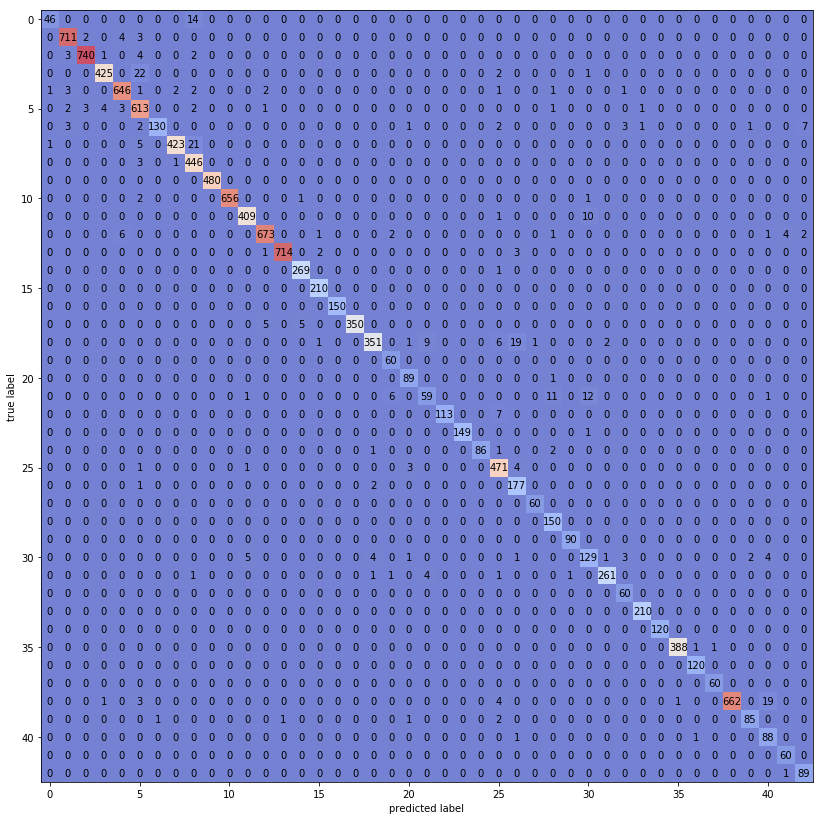

In [80]:
# predict and evaluate
y_predictions = model.predict_classes(X_test, verbose=0)
y_test_labels = np.array([int(x) for x in test_labels])
cm = confusion_matrix(y_target=y_test_labels, y_predicted=y_predictions, binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm,cmap='coolwarm',alpha=0.7)
fig.set_size_inches(14.2, 14.2)
plt.show()

- Next I apply predictions on the unseen test data which maintains the orginal class distribution.
- A Confusion Matrix is a very useful tool for answering the right questions for the right machine learning task like classification.
- From the above CM I can make a few observation:-
    - The model is mostly making the right predictions by matching the correct labels to the test images.
    - There are a few misclassifications at the top left where the speed signs are clustered which means the model is sometimes having a difficulty interpreting the numbers on the signs. 
    I can observe that Class 5 was misclassified as Class 3 (80km/h as 60km/h)
    - This can be tackled with the use of [Branch Convolutional Networks](https://arxiv.org/abs/1709.09890) to tackle this sort of heirchy feature existence in data.
    - The top right part of the CM also contains signs with circular images which account for the majority of the dataset even after class balancing.
    - Class 18 was misclassified a 19 times as Class 26 ( Caution sign for Traffic sign). Arguably similar with poor images.
    - Class 40 was misclassified a 19 times as Class 38 ( Roundabout mandatory for Keep right). They both have circular outer sign with an arrow pointing in a sideways direction.
    - An interesting note to make is how well the under represented classes have performed reasonably well after generating more samples through data augmentation. Class 39 had 270 samples and only has 2 misclassification. Classes 41 and 42 had the least amout of samples at 210 and have one misclassification between them.
    - This is proof that more data is usually better when training a machine learning model.

#### failed model predictions

- I visualize the worst probability misclassifications to understand where the model is getting stuck.
- This is important to help me understand what preprocessing could be done better or different, what other model architectures to explore for better feature detection among other things.

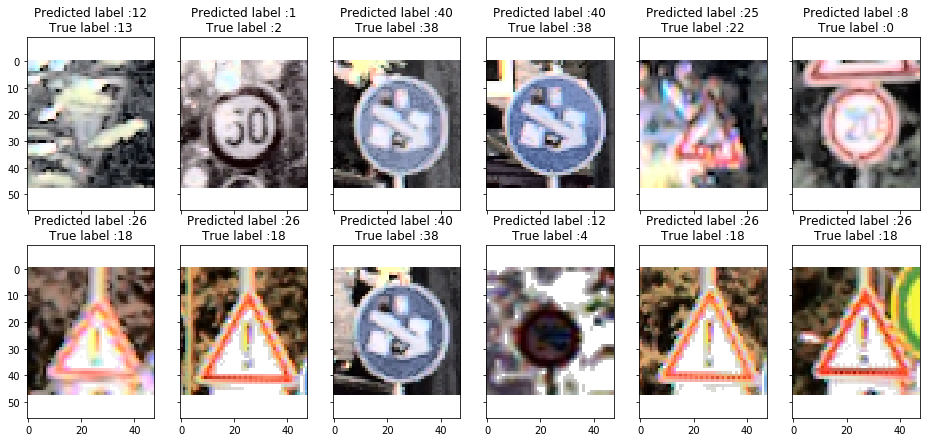

In [82]:
# Visualize failed model predictions
# CREDIT: https://gist.github.com/ECHO-ECHOOooo/38b9af3f654695d3a63d1b2cccb39417
# for the displaying predictions errors to Visualize failed model predictions

y_predictions = model.predict(X_test)
y_predictions_classes = np.argmax(y_predictions,axis = 1) 
y_true = np.argmax(y_test,axis = 1) 

err = (y_predictions_classes - y_true != 0)
y_predictions_classes_err = y_predictions_classes[err]
y_predictions_err = y_predictions[err]
y_true_err = y_true[err]
X_test_err = X_test[err]


y_predictions_err_prob = np.max(y_predictions_err,axis = 1)

true_prob_err = np.diagonal(np.take(y_predictions_err, y_true_err, axis=1))

delta_predictions_true_err = y_predictions_err_prob - true_prob_err

sorted_delta_err = np.argsort(delta_predictions_true_err)


def display_err(err_index,img_err,predictions_err, obs_err):
    n = 0
    nrows = 2
    ncols = 6
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    fig.set_size_inches(16,7)
    for row in range(nrows):
        for col in range(ncols):
            err = err_index[n]
            ax[row,col].imshow((img_err[err]))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictions_err[err],obs_err[err]))
            n += 1



# Top  errors 
most_important_err = sorted_delta_err[-12:]

# Show the top  errors
display_err(most_important_err, X_test_err, y_predictions_classes_err, y_true_err)

- As pointed above, the speed signs are a hiccup for the model but also the General caution for Traffic signals. 
- Class 12 and 13 are also quite simialr in that they are straight shapes with empty space between them.
- Below I visualize samples from these two classes to show the similarities that exist between them.

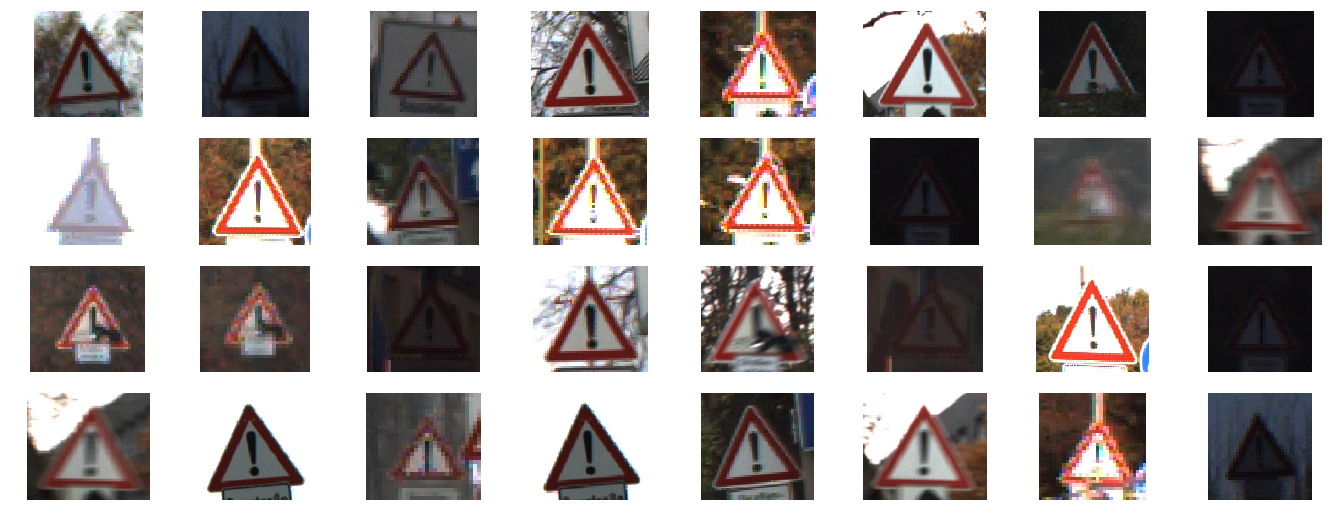

In [83]:
# 18. General caution
get_class_samples(18)

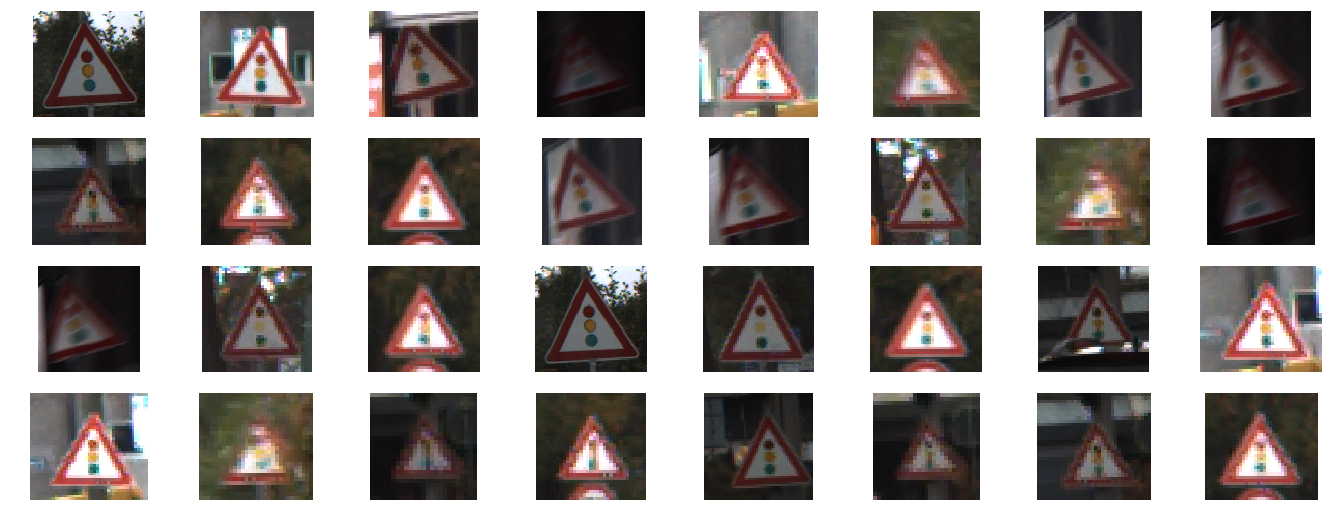

In [84]:
# 26. Traffic signals
get_class_samples(26)

#### Predicting Unseen Web Images

- The point of teaching a machine to learn the traffic signs is so that it can be used in a real life so I am going to test this learnt knowledge on images from outside world.
- I have to point out that it is not as easy to find good samples on the web without copyright protection but then again no one is in the habbit of posting bad traffic sign images online. It's unremarkable.
- However, i intetionally got images that would throw the model off for better observations about my trained network
- I can now appreciate the process of collecting data including intentional bad data to help a model generalize better. I can't imagine how long it took the team that put this data together.
- Ok. Let's do some predicting.

In [26]:
# get web samples and process before prediction
# OpenCV reads images in BGR format so had to change that to RGB for sake of visualizing

def conv_BGR2RGB(img):
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return imgRGB
# ________________________________________________________________

trainSized48p = np.array([resized48p(img) for img in train_balanced_imgs])    
    
web_samples = None
web_samples = [cv2.imread(file) for file in glob.glob('GTSRB/Internet_Samples/*.jpg')]
web_samples = [conv_BGR2RGB(img) for img in web_samples]
web_samples = [resized48p(img) for img in web_samples]
web_samples = [color_img_hist_equal(img) for img in web_samples]

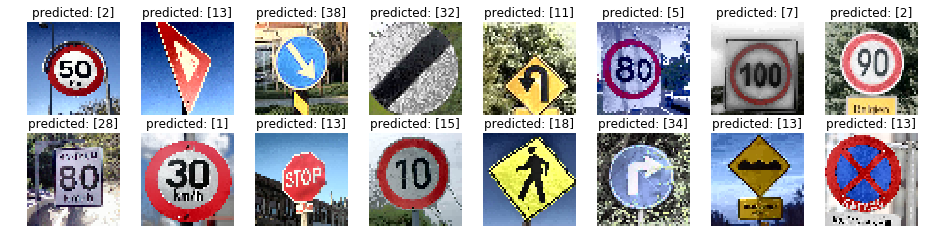

In [27]:
# Web Samples Prediction and Vis
web_samples = web_samples[20:36]
plt.figure(figsize=(16, 16))
for i in range(len(web_samples)):
    p = model.predict_classes(np.expand_dims(web_samples[i], axis=0))
    plt.subplot(8, 8, i+1)
    plt.imshow(web_samples[i]) 
    plt.title('predicted: {}'.format(p))
    plt.axis('off')
plt.show()

- In all I had 16 images which the model predicted only 5 correct.
- I can see why some of them would be misclassified as they were intentionally misleading.
- Index 3 was predicted as Priority road even though the two are not all that simialr.
- The 90km/h was classified as 70km/h but the model was not trained on 90.
- The 80km/h was classified as a stop sign which is a really bad prediction.
- Overall most of the misclassifications are of signs that the model has not trained on but I can see why it would make most of these predictions.
- This is a very good exercise as it is not always possible to think of good scenarios to train a machine but to throw unpredictable data at it.

#### Conclusions

- Doing this course and project has been a very great learning experience and has put me in the front seat of tomorrows great technological advances and I am glad I will no longer be a spectator but an active participant.
- With that said, I am already thinking of the many ways to perfect a model that handles this kind of image classification.
- For this particular task I think paying close attention to particular signs when augmenting them would be helpful. The signs with arrows could easily be interpreted as different signs by the model if they are augmented improperly.
- Different model architectures could also prove to be better especially when you read the papers associated with how they perform classifications.
- Transferred learning is another one that comes to mind. I did experiment with this  using the original VGG16 weights but didn't do so well.
- I also came across an [article on Google Deepmind work on Spatial Transformers Networks](http://torch.ch/blog/2015/09/07/spatial_transformers.html) which sample image spaces and extract geometric shapes which further with the task of feature extraction. I think these would come in handy here as the blog article shows, the researchers were able to to outperform the GTSRB contest winners by achieving an accuracy of 99.61%.
- Also worth exploring is better methods of balancing class imbalances (Over sampling and Under sampling classes) and different optimizers.
- In conclusion, as with most research, the idea is to keep exploring, testing and improving even without enough data because in the real world the right kind of data is not always available.
- I look forward to more learning and using that knowledge to build better Machine Learning Models.